# Лабораторная работа №3

**Тема**: "Нелинейные ИНС в задачах прогнозирования."

**Цель работы**: "Изучить обучение и функционирование нелинейной ИНС при решении задач прогнозирования."

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

class lab():
    def __init__(self, a, b, c, d, step, L, Lhid, alpha, Ee):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.step = step
        self.L = L
        self.Lhid = Lhid
        self.alpha = alpha
        self.Ee = Ee

    def generate_etalons(self):
        a = self.a
        b = self.b
        c = self.c
        d = self.d
        step = self.step
        number = 30

        etalons = np.zeros(number)
        for i in range(number):
            x = i * step
            y = a * math.cos(b * x) + c * math.sin(d * x)
            etalons[i] = y
        return etalons

    def SigmFunc(self, S):
        y = 1 / (1 + math.exp(-S))
        return y

    def dSigmFunc(self, y):
        dy = y * (1 - y)
        return dy

    def BiSigmFunc(self, S):
        y = 2 / (1 + math.exp(-S)) - 1
        return y

    def dBiSigmFunc(self, y):
        dy = 2 * (1 - y) * y
        return dy

    def HyperbolicTangent(self, S):
        y = (math.exp(S) - math.exp(-S)) / (math.exp(S) + math.exp(-S))
        return y

    def dHyperbolicTangent(self, y):
        y = 1 - y ** 2
        return y

    def alg(self, funcCase, graphMark, graphLabel):
        e = self.generate_etalons()
        L = self.L
        Lhid = self.Lhid
        alpha = self.alpha
        Ee = self.Ee

        # массив размером [L x Lhid] для весов от входа к скрытому слою
        w = np.zeros((L, Lhid)) 
        for i in range(L):
            for j in range(Lhid):
                w[i][j] = random.uniform(0, 0.5)
        # массив размером [Lhid x 1] для весов от скрытого слоя к выходу
        ws = np.zeros(Lhid) 
        for i in range(Lhid):
            ws[i] = random.uniform(0, 0.5)
        # пороги от входов к срытому слою
        T = np.zeros(Lhid) 
        for i in range(Lhid):
            T[i] = random.uniform(0, 0.5)
        # порог от скрытого слоя к выходу
        Ts = random.uniform(0, 0.5) 
        # цикл
        eras = 0
        valueXforGraph = []
        valueYforGraph = []
        while 1:
            for k in range(30 - L):
                x = np.zeros(L)
                for i in range(L):
                    x[i] = e[i + k]
                # S = [x] * [w] - [T]
                S = x.dot(w) - T  

                for i in range(Lhid):
                    # [SigmFunc(S1), ..., SigmFunc(SLhid)]
                    if funcCase == 1:
                        S[i] = self.SigmFunc(S[i]) 
                    elif funcCase == 2:
                        S[i] = self.BiSigmFunc(S[i])
                    else:
                        S[i] = self.HyperbolicTangent(S[i]) 
                y = S

                # Y = [y] * [ws] - [Ts]
                Y = y.dot(ws) - Ts 

                gamma = Y - e[k]

                # [ws] = [ws] - a * j * 1 * Y
                ws = ws - alpha * gamma * 1 * y 

                # [Ts] = [Ts] + a * j * 1
                Ts = Ts + alpha * gamma * 1 

                gamma_s = np.zeros(Lhid)
                for i in range(Lhid):
                    gamma_s[i] = y[i] - e[k + i]

                for i in range(L):
                    for j in range(Lhid):
                        if funcCase == 1:
                            w[i][j] -= alpha * gamma_s[j] * self.dSigmFunc(y[j]) * y[j]
                        elif funcCase == 2:
                            w[i][j] -= alpha * gamma_s[j] * self.BiSigmFunc(y[j]) * y[j]
                        else:
                            w[i][j] -= alpha * gamma_s[j] * self.HyperbolicTangent(y[j]) * y[j]

                for i in range(Lhid):
                    if funcCase == 1:
                        T[i] += alpha * gamma_s[i] * self.dSigmFunc(y[j])
                    elif funcCase == 2:
                        T[i] += alpha * gamma_s[i] * self.BiSigmFunc(y[j])
                    else:
                        T[i] += alpha * gamma_s[i] * self.HyperbolicTangent(y[j])
 
                E = 0.5 * (Y - e[k]) ** 2

            eras += 1
            valueXforGraph.append(eras)
            valueYforGraph.append(E)
            print('\r%10d %32.20f' % (eras, E), end = '')
            if E < Ee:
                break
        print()
        plt.plot(valueXforGraph, valueYforGraph, graphMark, label=graphLabel)

In [2]:
obj = lab(
    0.1,    #a      для функции y = a cos(b x) + c sin(d x)
    0.5,    #b      для функции y = a cos(b x) + c sin(d x)
    0.09,   #c      для функции y = a cos(b x) + c sin(d x)
    0.5,    #d      для функции y = a cos(b x) + c sin(d x)
    0.1,    #step   для функции y = a cos(b x) + b sin(d x)
    8,      #L - количество входов ИНС
    3,      #Lhid - количество НЭ в скрытом слое
    0.01,    #alpha - скорость обучения
    1e-6    #Ee - средняя квадратичная ошибка, до которой мы хотим очучить сеть
)

       392           0.00000099960130984633


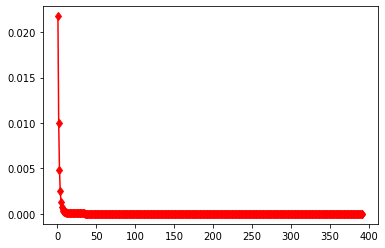

In [3]:
obj.alg(1, 'd-r', 'Sigmoid function')

     42224           0.00000099998494622475


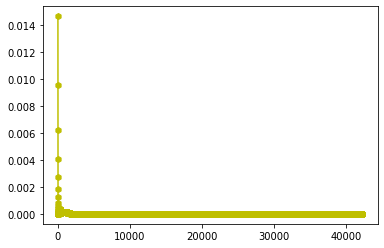

In [4]:
obj.alg(2, 'h-y', 'Bipolar sigmoid function')

     12639           0.00000099995534539331


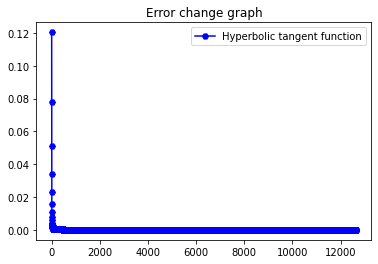

In [7]:
obj.alg(3, 'H-b', 'Hyperbolic tangent function')
plt.title("Error change graph") # Python write title in graph
plt.legend() # Python write legend in graph
plt.show() # Python open new windows and show graph

**Вывод**: "..."